In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm.notebook import tqdm
import sys
import os
import time
import emcee
from numpy import linalg
import scipy
import cosmopower as cp
sys.path.append(os.path.join(os.path.dirname("__file__"), '../cosmopower'))
import likelihoods.tf_planck2018_lite as cppl
%matplotlib inline

In [2]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))

tt_emu_model = cp.cosmopower_NN(restore=True,
                                restore_filename=os.path.join(ipynb_path, '../cosmopower/trained_models/CP_paper/CMB/cmb_TT_NN')
                               )

te_emu_model = cp.cosmopower_PCAplusNN(restore=True,
                                restore_filename=os.path.join(ipynb_path, '../cosmopower/trained_models/CP_paper/CMB/cmb_TE_PCAplusNN')
                               )

ee_emu_model = cp.cosmopower_NN(restore=True,
                                restore_filename=os.path.join(ipynb_path, '../cosmopower/trained_models/CP_paper/CMB/cmb_EE_NN')
                               )

In [3]:
# path to the tf_planck2018_lite likelihood
tf_planck2018_lite_path = './../cosmopower/likelihoods/tf_planck2018_lite/'

# parameters of the analysis, and their priors
parameters_and_priors = {'omega_b':      [0.001, 0.04, 'uniform'],
                         'omega_cdm':    [0.005, 0.99,  'uniform'],
                         'h':            [0.2,   1.0,   'uniform'],
                         'tau_reio':     [0.01,  0.8,   'uniform'],
                         'n_s':          [0.9,   1.1,   'uniform'],
                         'ln10^{10}A_s': [1.61,  3.91,  'uniform'],
                         'A_planck':     [1.0,   0.01,  'gaussian'],
                          }


In [4]:
# instantiation
tf_planck = cppl(parameters=parameters_and_priors, 
                                  tf_planck2018_lite_path='/home/grads/data/evan/cosmopower_emcee/cosmopower/likelihoods/tf_planck2018_lite',
                                  tt_emu_model=tt_emu_model,
                                  te_emu_model=te_emu_model,
                                  ee_emu_model=ee_emu_model
                                  )

In [14]:
X_data = tf_planck.X_data[0]
fisher = tf_planck.fisher
print(X_data.shape)
print(fisher.shape)

(613,)
(613, 613)


In [40]:
noisy_planck = np.random.multivariate_normal(X_data,np.linalg.inv(fisher),size=5000)
print(noisy_planck.shape)

(5000, 613)


In [41]:
# chisq
chisq = []

for i in range(noisy_planck.shape[0]):
    dv = noisy_planck[i]
    _chisq = [dv-X_data] @ fisher @ np.transpose([dv-X_data])
    chisq.append(_chisq[0][0])

print(np.array(chisq).shape)

(5000,)


Text(0.5, 0, '$\\chi^2$')

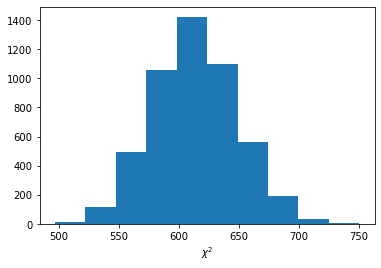

In [42]:
plt.hist(chisq)
plt.xlabel('$\chi^2$')

In [43]:
np.savetxt('/home/grads/data/evan/noisy_planck.txt',noisy_planck)